<a href="https://colab.research.google.com/github/OleksiiLatypov/Practical_Deep_Learning_with_PyTorch/blob/main/week3/new_prob_notebook0f04550e55.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rsna-pneumonia-detection-challenge:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F10338%2F862042%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240512%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240512T200228Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D04383700f5d3651839f5f1f3b4a1ae49f759db3eed000bf754799a9d6c91da808621dc144afa579078bc50f8607dbebed8981dc2849ad2e4a5ca34eb2ace5b88e3fe2ffb964bdac5ca33dc98c78fa8799a37e424757f08f4a1385e00af8cdef22dc58a98b76ae36d12f15d8d43a5fc7f96c061315c06b95bb7bbec46076f51891937b5cf128d17d2b3431eddd6d21455d17219caed4ac7d73f9c4c0e0e28c295cf5e70ab4eeb9ff549087815f0250d3528fde17099dfecc841b9065613bdbde259a3172edea4228002d6b3576c42732f68f57f7fb7a4cda79dedf7744669b10ec87d6fe410de5c451128f001d8c4d2e1445936f8a83fa7721b7b88b9e32f67c5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3932287530 bytes downloaded
Downloaded and uncompressed: rsna-pneumonia-detection-challenge
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install albumentations==0.0.9

In [ ]:
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from sklearn.model_selection import train_test_split
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data.sampler import SequentialSampler
from pydicom import dcmread

import torch
from torchvision import transforms
from torchvision import transforms as T
import torch.nn as nn
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pydicom as pyd
from tqdm import tqdm

import cv2
import re
import time
import matplotlib
import os

from albumentations.pytorch.transforms import ToTensorV2
from tqdm import tqdm
import albumentations as A

from albumentations import (
    Resize,
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

ImportError: cannot import name 'IAAPerspective' from 'albumentations' (/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py)

In [ ]:
images_path = '../input/rsna-pneumonia-detection-challenge/stage_2_train_images'
train_labels_df = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
label_meta_data = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')

In [ ]:
train_labels_df

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  185.0  298.0  228.0   379.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
30222       1  
30223       0  
30224       0  
30225       1  
30226       1  

[30227 rows x 6 columns]

In [ ]:
label_meta_data

patientId                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2      00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4      00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity
...                                     ...                           ...
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8                  Lung Opacity
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba                        Normal
30224  c1f6b555-2eb1-4231-98f6-50a963976431                        Normal
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity

[30227 rows x 2 columns]

In [ ]:
len(np.unique(label_meta_data['patientId']))

26684

In [ ]:
len(label_meta_data['patientId'].unique())

26684

In [ ]:
label_meta_data.shape

(30227, 2)

In [ ]:
unique_patientId = train_labels_df.drop_duplicates(subset = ['patientId'])
unique_patientId

patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN   
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN   
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN   
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0   
...                                     ...    ...    ...    ...     ...   
30219  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  666.0  418.0  186.0   223.0   
30221  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  609.0  464.0  240.0   284.0   
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba    NaN    NaN    NaN     NaN   
30224  c1f6b555-2eb1-4231-98f6-50a963976431    NaN    NaN    NaN     NaN   
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   

       Target  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
30219       1  
30221       1  
30223       0  
30224       0  
30225       1  

[26684 rows x 6 columns]

**Selecting instances with inflammation¶**

In [ ]:
print('Original dataframe shape:', train_labels_df.shape)

train_labels_df_pos = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height'])

k = 0
for i in range(len(train_labels_df)):
    if train_labels_df.loc[i]['Target'] == 1:
        train_labels_df_pos.loc[k] = train_labels_df.loc[i]
        k += 1

print('Positive instances dataframe shape:', train_labels_df_pos.shape)
train_paths = [os.path.join(images_path, image[0]) for image in train_labels_df_pos.values]

Original dataframe shape: (30227, 6)
Positive instances dataframe shape: (9555, 5)


In [ ]:
train_labels_df_pos.head()

patientId      x      y  width height
0  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0  379.0
1  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0  453.0
2  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0  104.0
3  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0  137.0
4  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0  135.0

**Visualization of the images and the areas of inflammation**

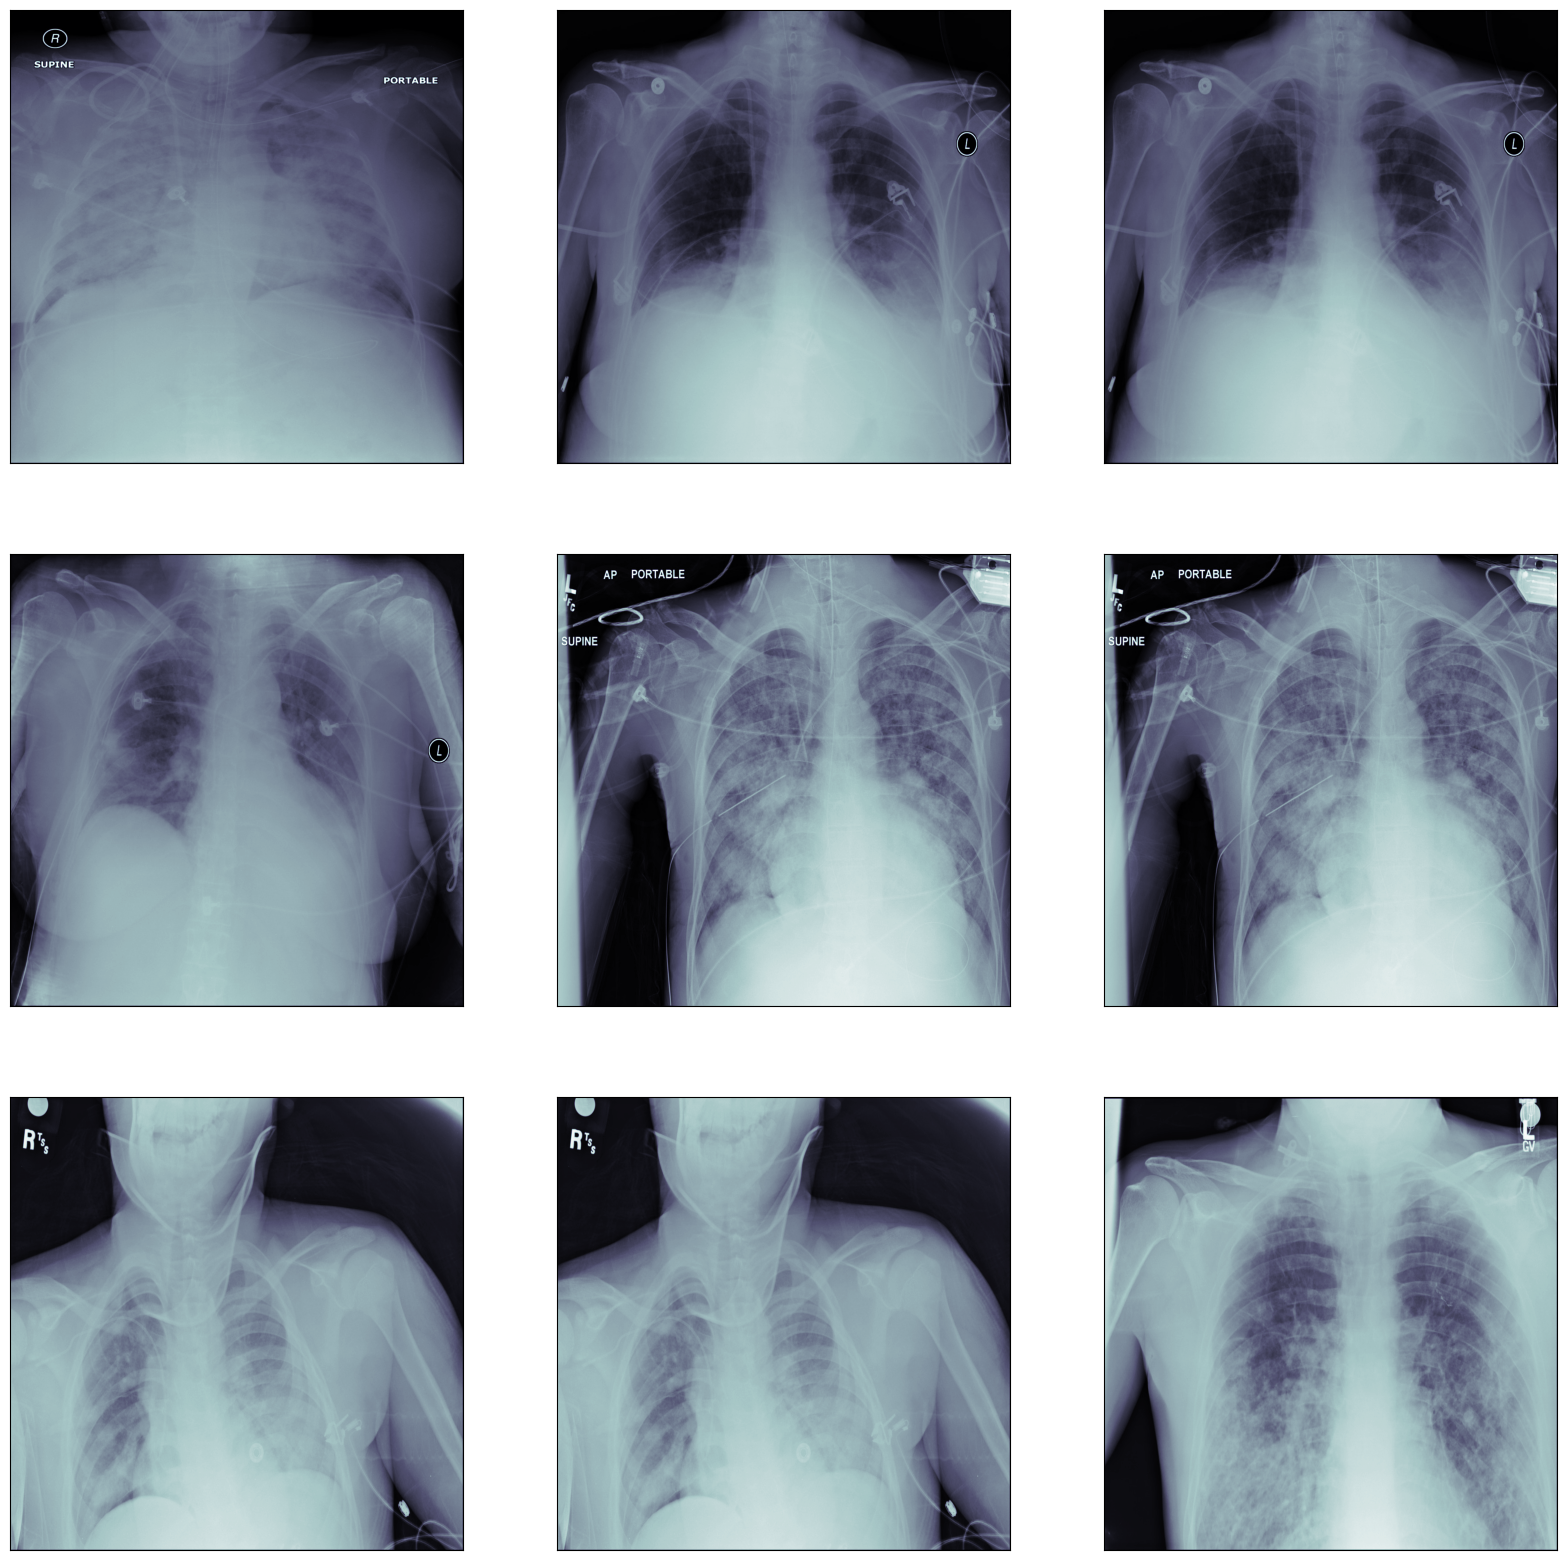

In [ ]:
def imshow(num_to_show=9):

    plt.figure(figsize=(20,20))

    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap='bone')

imshow()

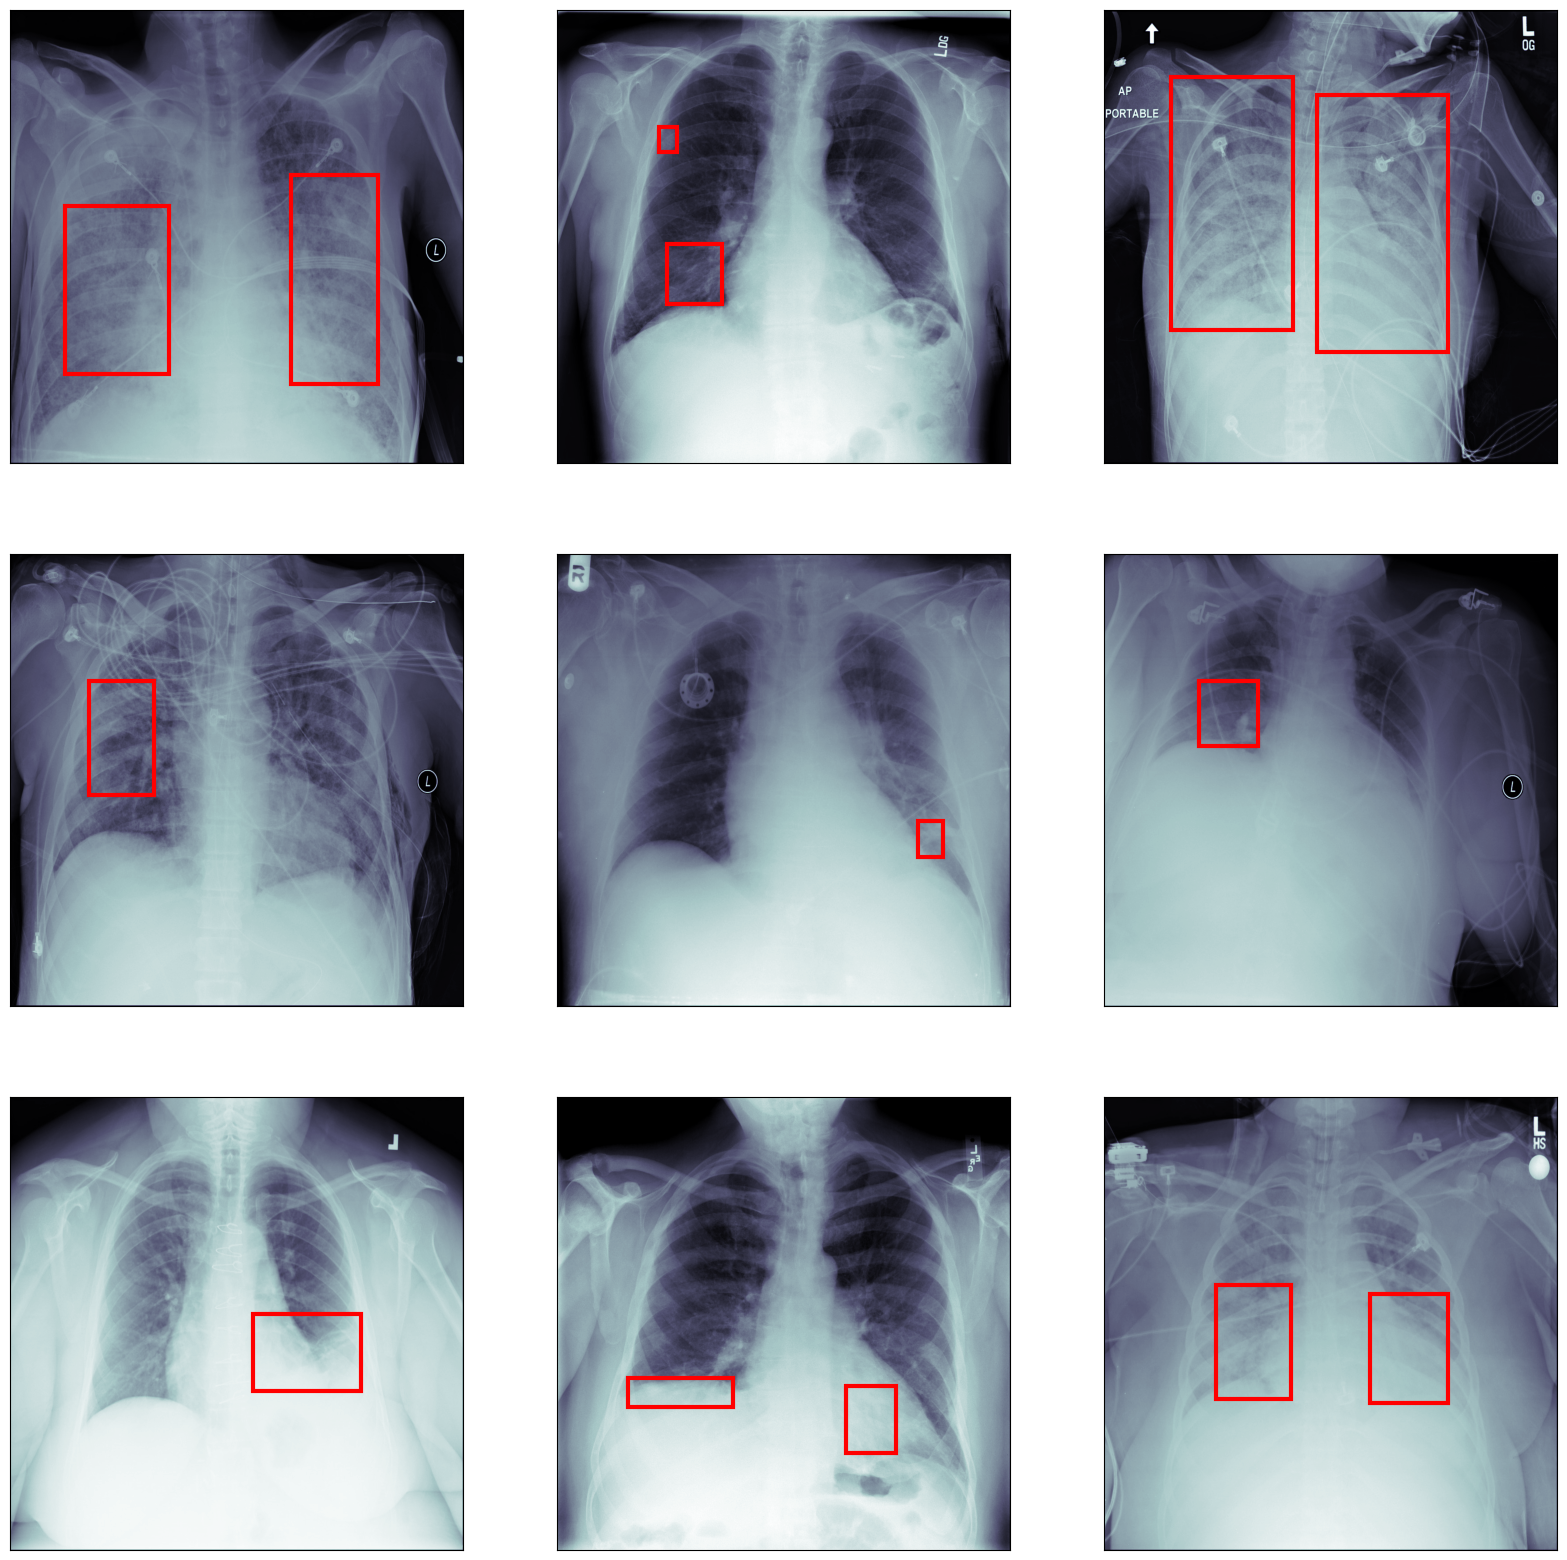

In [ ]:
def show_image_with_bboxes(num_to_show=9):
    plt.figure(figsize=(20,20))

    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])

        id_= np.random.choice(train_labels_df_pos['patientId'].values)

        current_axis = plt.gca()
        img=pyd.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
        plt.imshow(img,cmap='bone')


        current_axis = plt.gca()
        boxes=train_labels_df_pos[['x','y','width','height']][train_labels_df_pos['patientId']==id_].values

        for box in boxes:
            x=box[0]
            y=box[1]
            w=box[2]
            h=box[3]
            current_axis.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

show_image_with_bboxes()

In [ ]:
def parse_one_annot(data, patient_id):
    boxes_array = data[data["patientId"] == patient_id][["x", "y", "width", "height"]].values
#     print(boxes_array.dtype)
    return boxes_array

In [ ]:
def show_one_with_bbox(id_):
    plt.figure(figsize=(20,20))
    current_axis = plt.gca()
    img=pyd.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
    plt.imshow(img,cmap='bone')

    current_axis = plt.gca()
    boxes=train_labels_df_pos[['x','y','width','height']][train_labels_df_pos['patientId']==id_].values
    for box in boxes:
        x=box[0]
        y=box[1]
        w=box[2]
        h=box[3]
        current_axis.add_patch(plt.Rectangle((x, y), w, h, color='red', fill=False, linewidth=3))

Id 321cd5e5-6a3d-43a8-a175-e06793dbea00
Bboxes [[313.0 353.0 194.0 333.0]]


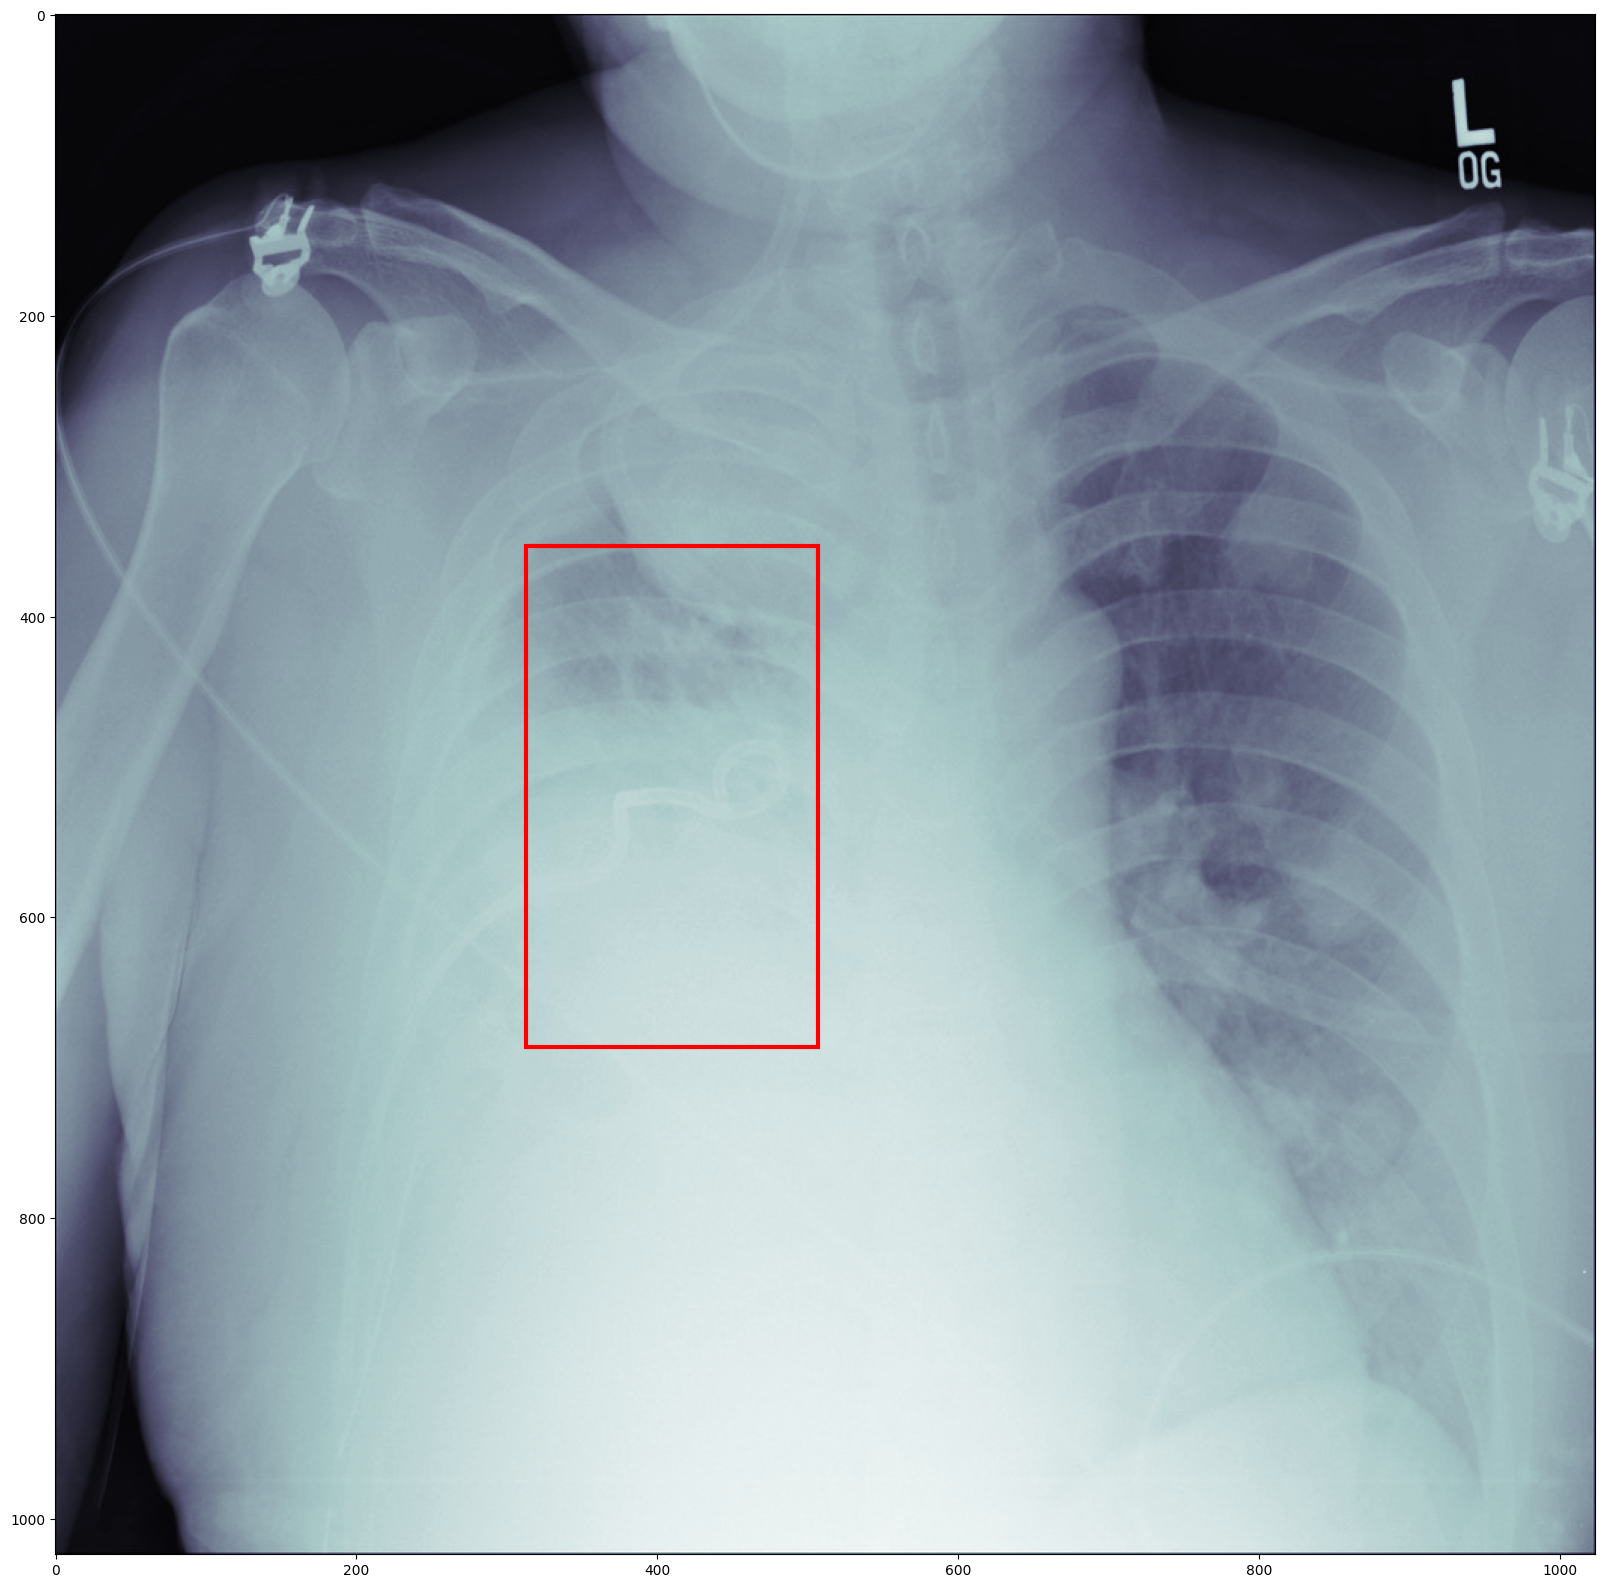

In [ ]:
id_= np.random.choice(train_labels_df_pos['patientId'].values)
print('Id', id_)
print('Bboxes', parse_one_annot(train_labels_df_pos, id_))
show_one_with_bbox(id_)

**Preparing data for training. Dataset class. Tranformations**

In [ ]:
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['patientId'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index):
        # load images and bounding boxes
        image_id = self.image_ids[index]
        records = self.df[self.df['patientId'] == image_id]

#         img_path = os.path.join(self.image_dir, image_id)
#         img=pyd.read_file(os.path.join(img_path+'.dcm')).pixel_array
        img = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
#         img = img/255
        img /= 255.0

        boxes = records[['x', 'y', 'width', 'height']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['patientId'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': img,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            img = sample['image']

            target['boxes'] = torch.stack(tuple(map(torch.FloatTensor, zip(*sample['bboxes'])))).permute(1, 0)

        return img, target


    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
# Albumentations
def get_train_transform():
    return A.Compose([
        Resize(300,  300),
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

**Train and Validation split**

In [ ]:
input_folder = '../input/rsna-pneumonia-detection-2018/input'
images_folder = f"{input_folder}/images/"

image_ids = train_labels_df_pos['patientId'].unique()
valid_ids = image_ids[-300:]
train_ids = image_ids[:-300]
print(f"Training instance: {len(train_ids)}")
print(f"Validation instances: {len(valid_ids)}")

valid_df = train_labels_df_pos[train_labels_df_pos['patientId'].isin(valid_ids)]
train_df = train_labels_df_pos[train_labels_df_pos['patientId'].isin(train_ids)]

print('Train dataframe shape:', train_df.shape)
print('Valid dataframe shape:', valid_df.shape)

train_dataset = PneumoniaDataset(train_df, images_folder, get_train_transform())
valid_dataset = PneumoniaDataset(valid_df, images_folder, get_valid_transform())
print('train_dataset and valid_dataset are loaded :)')
print("We have: {} training examples and {} validation examples".format(len(train_dataset), len(valid_dataset)))

Training instance: 5712
Validation instances: 300
Train dataframe shape: (9057, 5)
Valid dataframe shape: (498, 5)


NameError: name 'MotionBlur' is not defined